# Calibrate Camera with Charuco

using a folder with images.....



first version was based on https://mecaruco2.readthedocs.io/en/latest/notebooks_rst/Aruco/sandbox/ludovic/aruco_calibration_rotation.html


In [2]:
import glob
import numpy as np
import cv2
from cv2 import aruco

import os

import json

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

%matplotlib notebook

#mpl.rcParams['figure.figsize'] = [12, 8]

#%matplotlib nbagg
print("opencv version",cv2.__version__)

opencv version 3.4.1


## Make the charuco board

board size in mm 175.00000000000003 x 245.00000000000003


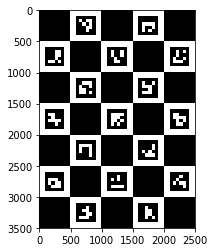

In [3]:
squareLength = 35.0 / 1000 # chessboard square side length (normally in meters)
markerLength = 22.0 / 1000 # marker side length (same unit than squareLength)
squaresX = 5
squaresY = 7

dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_250)
board = cv2.aruco.CharucoBoard_create(squaresX,squaresY,squareLength,markerLength,dictionary)

s = 500
img = board.draw((s*squaresX,s*squaresY))

print("board size in mm {} x {}".format(squaresX*squareLength*1000,squaresY*squareLength*1000))

#
# uncomment to save
#
cv2.imwrite('board.png',img)

# show the board below
figure1 = plt.figure()
plt.imshow(img, cmap = mpl.cm.gray, interpolation = "nearest")


## Load Images 

In [3]:
images = glob.glob("sample-data/frame*.jpg")
images.sort()

print("{} image files found".format(len(images))) 


11 image files found


image shape: (720, 1280, 3)


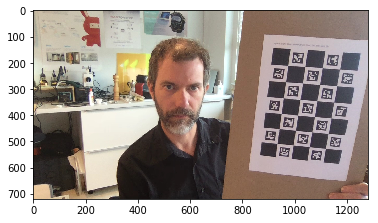

In [4]:
i = 0
figure1 = plt.figure()
img = cv2.imread(images[i])
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),  interpolation = "nearest")
print("image shape: {}".format(img.shape))

imsize = (img.shape[0], img.shape[1])


In [5]:
allCorners=[]
allIds=[]
images2=[]

# function because we use later
def find_charuco_board(img, board, dictionary):
    corner_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, dictionary)    
    if len(corners)>0:
        for corner in corners:
            cv2.cornerSubPix(gray, corner, winSize=(3,3), zeroZone=(-1,-1), criteria=corner_criteria)        
        ret, detectedCorners, detectedIds = cv2.aruco.interpolateCornersCharuco(corners,ids,gray,board)
        if detectedCorners is not None and detectedIds is not None and len(detectedCorners)>3:
            return detectedCorners, detectedIds
    return [], []

for i in images:
    img = cv2.imread(i)
    corners, ids = find_charuco_board(img, board, dictionary)
    if len(corners) > 0:
        allCorners.append(corners)
        allIds.append(ids)
        images2.append(i)
            
images = images2 # filter out the skipped images


print("images left {}".format(len(images2)))



images left 11


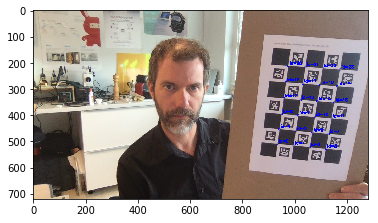

number of corners: 24


In [6]:
# draw a corner

i = 0
figure1 = plt.figure()
img = cv2.imread(images[i])
img = cv2.aruco.drawDetectedCornersCharuco(img, allCorners[i], allIds[i])

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),  interpolation = "nearest")
plt.show()

print("number of corners: {}".format(len(allCorners[i])))



## Perform Calibration

In [7]:
flags = (cv2.CALIB_USE_INTRINSIC_GUESS + cv2.CALIB_RATIONAL_MODEL + cv2.CALIB_FIX_ASPECT_RATIO) 
criteria=(cv2.TERM_CRITERIA_EPS & cv2.TERM_CRITERIA_COUNT, 10000, 1e-9)
distCoeffsInit = np.zeros((5,1))

cameraMatrixInit = np.array([[ 1000.,    0., imsize[0]/2.],
                             [    0., 1000., imsize[1]/2.],
                             [    0.,    0.,           1.]])



%time (ret, cameraMatrix, distCoeffs, rvecs, tvecs)  = aruco.calibrateCameraCharuco(allCorners,allIds,board,imsize,cameraMatrixInit,distCoeffsInit,flags = flags,criteria = criteria)

print("reprojection error {}".format(ret))



CPU times: user 96.4 ms, sys: 19.2 ms, total: 116 ms
Wall time: 93.5 ms
reprojection error 0.2617811337106627


In [8]:
cameraMatrix

array([[1.00368905e+03, 0.00000000e+00, 6.36708978e+02],
       [0.00000000e+00, 1.00368905e+03, 4.14296824e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [9]:
distCoeffs

array([[-0.00851888],
       [-0.44933352],
       [ 0.00571404],
       [-0.00126107],
       [ 0.26073695],
       [-0.13493828],
       [ 0.10285917],
       [-0.34395347],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ]])

## check calibration result

(-0.5, 1279.5, 719.5, -0.5)

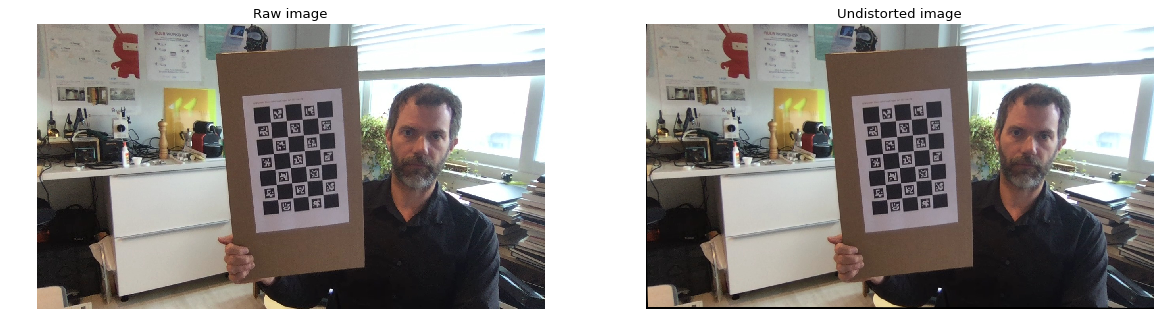

In [10]:
i=10 # select image id

plt.figure(figsize=(18, 10), dpi= 80)
img = cv2.imread(images[i])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_undist = cv2.undistort(img,cameraMatrix,distCoeffs,None)
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Raw image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img_undist)
plt.title("Undistorted image")
plt.axis("off")

Draw Coordinate axis

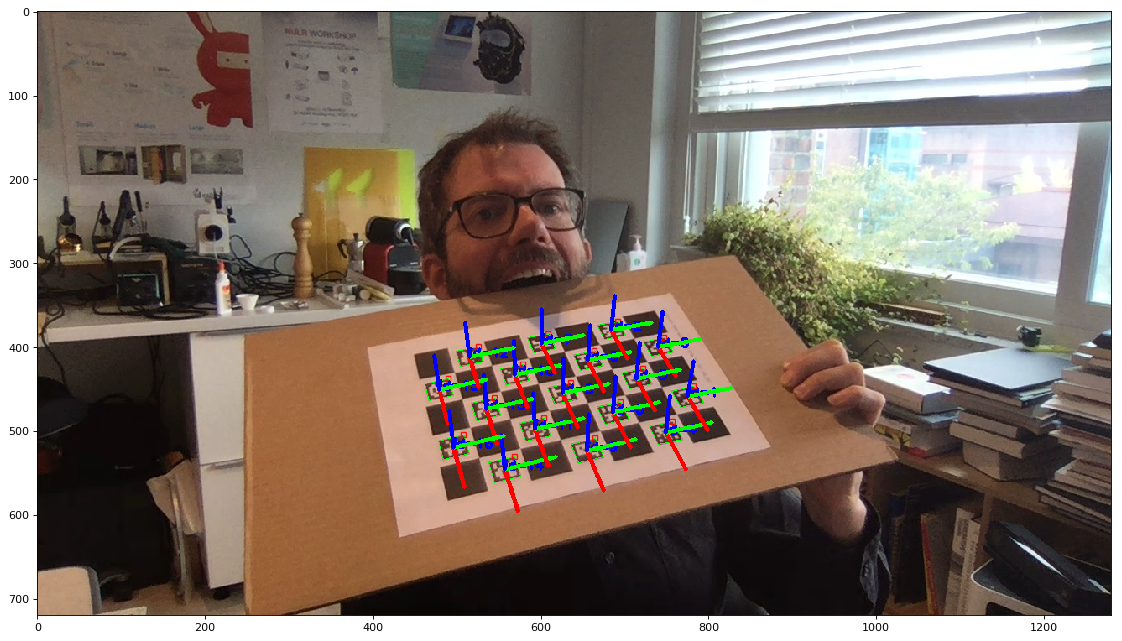

In [11]:
def find_aruco_markers(img, dictionary):
    corner_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.00001)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(gray, dictionary)    
    if len(corners)>0:
        for corner in corners:
            cv2.cornerSubPix(gray, corner, winSize=(3,3), zeroZone=(-1,-1), criteria=corner_criteria)        
        
        return corners, ids
    return [], []

i = 1
#test_img = cv2.imread(images[i])
test_img = cv2.imread("sample-data/test_frame_1.jpg")

corners, ids = find_aruco_markers(test_img, dictionary)

test_img_2 = aruco.drawDetectedMarkers(test_img, corners, ids)


rvecs,tvecs, objPts = aruco.estimatePoseSingleMarkers(corners, markerLength , cameraMatrix, distCoeffs)

for i in range(len(tvecs)):
    test_img_2 = aruco.drawAxis(test_img_2, cameraMatrix, distCoeffs, rvecs[i], tvecs[i], 2*markerLength)


    
    

plt.figure(figsize=(18, 10), dpi= 80)
plt.imshow(cv2.cvtColor(test_img_2, cv2.COLOR_BGR2RGB), interpolation = "nearest")


ax.azim -60
ax.elev 30


Text(0.5, 0, 'Z Label')

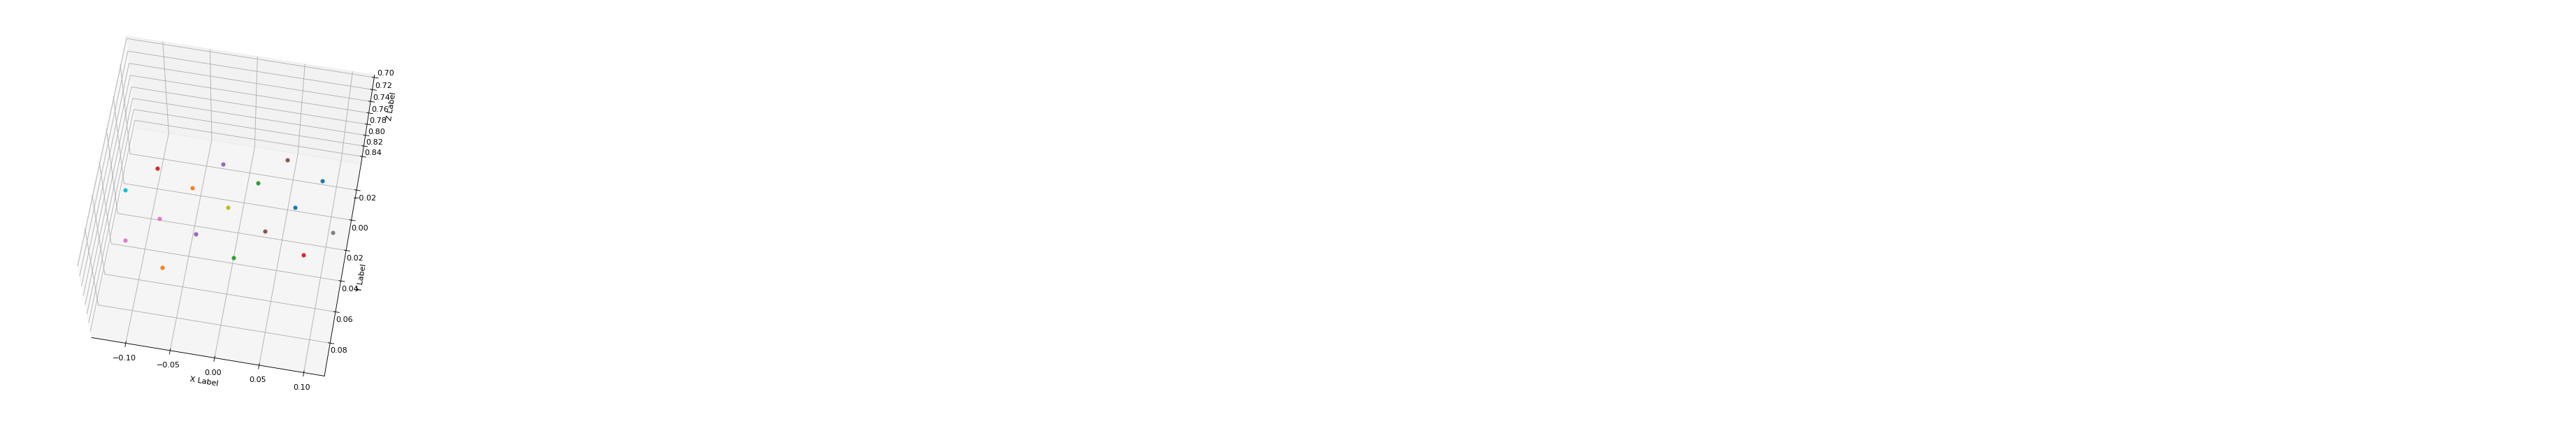

In [12]:
# plot the tvecs in 3D

fig = plt.figure(figsize=(10, 10), dpi= 80)

ax = fig.add_subplot(1,1,1, projection='3d')
print('ax.azim {}'.format(ax.azim))
print('ax.elev {}'.format(ax.elev))
ax.view_init(-110,260)
for p in tvecs:
    p2 = p[0]
    ax.scatter(p2[0],p2[1],p2[2])

    

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')





True [[ 1.92164432]
 [ 1.43070383]
 [-0.60678998]] [[-0.15052392]
 [-0.00349041]
 [ 0.78490316]]
[[ 0.29470236  0.95539911  0.01905431]
 [ 0.65039071 -0.18593101 -0.73649276]
 [-0.70010174  0.2294389  -0.67617701]]
{"rot3x3": [[0.2947023616180311, 0.9553991058571524, 0.0190543061828356], [0.6503907111237196, -0.18593100929249728, -0.7364927580549966], [-0.7001017361360689, 0.22943889886160806, -0.6761770114019221]]}


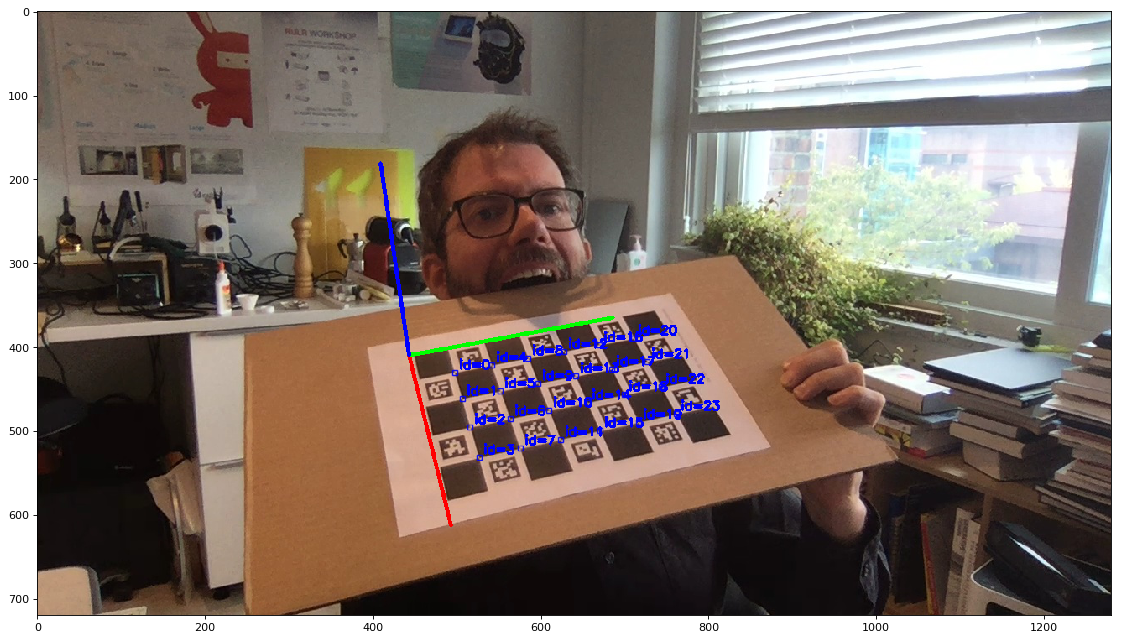

In [22]:
i = 1
#test_img = cv2.imread(images[i])
test_img = cv2.imread("sample-data/test_frame_1.jpg")

corners2, ids2 = find_charuco_board(test_img, board, dictionary)
img = cv2.aruco.drawDetectedCornersCharuco(test_img, corners2, ids2)
valid, rvec, tvec = cv2.aruco.estimatePoseCharucoBoard(corners2, ids2, board, cameraMatrix, distCoeffs)

print(valid, rvec, tvec)

# calculate the rotation matrix from the rvec    
rot3x3, _ = cv2.Rodrigues(rvec)
print(rot3x3)

a = {}
a["rot3x3"] = rot3x3.tolist()

print( json.dumps(a))

cv2.aruco.drawAxis(img, cameraMatrix, distCoeffs, rvec, tvec, 0.2) 

plt.figure(figsize=(18, 10), dpi= 80)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),  interpolation = "nearest")




## save calibration to file

Following the format of the opencv interactive calibration app

https://docs.opencv.org/3.4.0/d7/d21/tutorial_interactive_calibration.html
* cameraResolution        
* cameraMatrix
* dist_coeffs
* avg_reprojection_error
        

In [14]:
import datetime
filename = "calibration.json"
fs = cv2.FileStorage(filename, cv2.FILE_STORAGE_WRITE)
fs.write("calibrationDate", str(datetime.datetime.now()))
fs.write("cameraResolution",imsize)
fs.write("cameraMatrix", cameraMatrix)
fs.write("dist_coeffs", distCoeffs)
fs.release()



# save points to file

In [45]:
filename = "camera_points.json"


def makeRT(rvec, tvec):
    rot3x3, _ = cv2.Rodrigues(rvec)
    return{"t": { "x":tvec[0][0], "y":tvec[1][0], "z":tvec[2][0] }, "rot3x3" : rot3x3.tolist()}


for i in images:
    img = cv2.imread(i)    
    corners, ids = find_aruco_markers(img, dictionary)
    rvecs,tvecs, objPts = aruco.estimatePoseSingleMarkers(corners, markerLength , cameraMatrix, distCoeffs)
        
    tvecs_json = {}
    
    
    for j in range(len(ids)):
        p = { "x":tvecs[j][0][0], "y":tvecs[j][0][1], "z":tvecs[j][0][2] }
        tvecs_json[str(ids[j][0])] = p

    corners2, ids2 = find_charuco_board(img, board, dictionary)
    valid, rvec, tvec = cv2.aruco.estimatePoseCharucoBoard(corners2, ids2, board, cameraMatrix, distCoeffs)

    pose = makeRT(rvec, tvec)
    
    a = { "pose": pose, "markers":tvecs_json }
    
    
    print(a)
    
    filename = "points_image{}.json".format(os.path.basename(i))
    print(filename)
    with open(filename, "w") as write_file:
        json.dump(a, write_file)
    
    
    



{'pose': {'t': {'x': 0.14111383091411678, 'y': 0.08696145281611364, 'z': 0.6169617417124994}, 'rot3x3': [[0.9874292824544761, 0.05163008059457698, -0.1493912545272847], [0.08914970910423921, -0.9623844668182016, 0.2566485289139123], [-0.13052103860323822, -0.2667404596322861, -0.9548894101816653]]}, 'markers': {'16': {'x': 0.2662993192680311, 'y': 0.08232370717711356, 'z': 0.6035126385882983}, '15': {'x': 0.19520673544225906, 'y': 0.07568906852575992, 'z': 0.6104298938873698}, '14': {'x': 0.30520460125367155, 'y': 0.05129286233547108, 'z': 0.5939837494875753}, '13': {'x': 0.23243760968354635, 'y': 0.044697872560224644, 'z': 0.5967217936937634}, '12': {'x': 0.16137741702089362, 'y': 0.03796729780448893, 'z': 0.603435453272404}, '11': {'x': 0.2722748009891388, 'y': 0.014054895116271037, 'z': 0.5893444690296425}, '10': {'x': 0.19922834828948377, 'y': 0.007453596681293177, 'z': 0.5924071958954249}, '9': {'x': 0.30691599693756616, 'y': -0.01726956884502798, 'z': 0.5710660710268894}, '8': {'

{'pose': {'t': {'x': 0.44696563476560186, 'y': 0.3012825446853833, 'z': 1.1883367384140366}, 'rot3x3': [[0.9838207917718813, -0.1332503392255755, -0.11975390087014515], [-0.1320747357901254, -0.9910810663683448, 0.01773651747534258], [-0.12104922074642224, -0.0016330898486060647, -0.9926451627717885]]}, 'markers': {'8': {'x': 0.5316761096224276, 'y': 0.17315348639456818, 'z': 1.2112825023705807}, '6': {'x': 0.5752333668230181, 'y': 0.13562810436983427, 'z': 1.2350185148891446}, '15': {'x': 0.5130874800537764, 'y': 0.2868110941936094, 'z': 1.222680768478851}, '16': {'x': 0.5832409927513718, 'y': 0.2762346010927558, 'z': 1.211933946572836}, '12': {'x': 0.47693705665521385, 'y': 0.25773842395421, 'z': 1.2381088779961162}, '13': {'x': 0.5421375559950089, 'y': 0.24498834023143487, 'z': 1.2138562365186614}, '14': {'x': 0.625433417571791, 'y': 0.24005757808105177, 'z': 1.2293977559034404}, '10': {'x': 0.5093641912101218, 'y': 0.2173392165816609, 'z': 1.236567700820064}, '11': {'x': 0.56722351

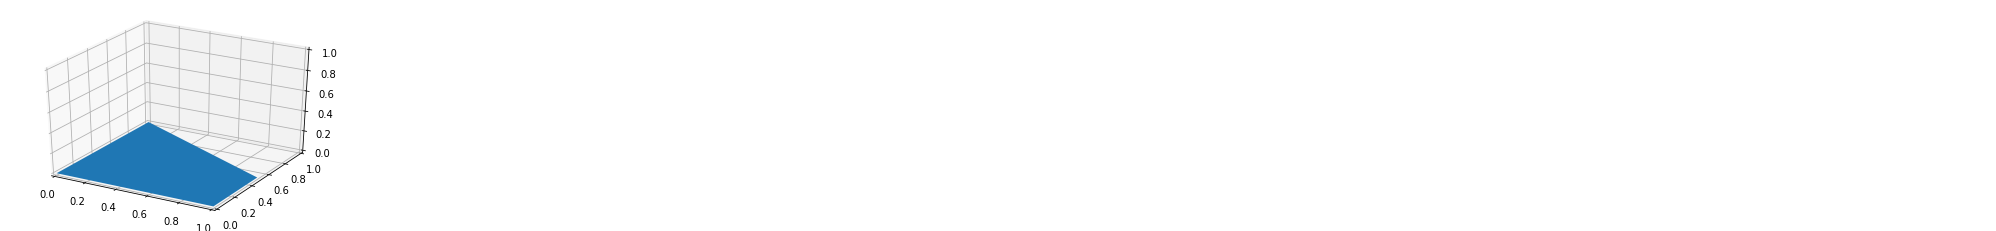

In [16]:
fig = plt.figure()
ax = fig.gca(projection='3d')
#ax = Axes3D(fig)
x = [0, 1, 1, 0]
y = [0, 0, 0.5, 1]
z = [0, 0, 0, 0]
verts = [list(zip(x, y, z))]
ax.add_collection3d(Poly3DCollection(verts), zs='z')